In [1]:
import yaml
import torch
import time
import numpy as np

from models import EdgeGNN, GAT, GCN, GraphSAGE, GIN, MLP, NodeEdgeGNN, SWEGNN
from data import FloodingEventDataset
from training import NodeRegressionTrainer, EdgeRegressionTrainer, DualRegressionTrainer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    # debug=True,
                    **config['dataset_parameters']).load()

In [6]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']

## Node Prediction Models

In [8]:
node_model_map = {
    'SWEGNN': SWEGNN,
    'GCN': GCN,
    'GAT': GAT,
    'GIN': GIN,
    'GraphSAGE': GraphSAGE,
    'MLP': MLP,
}

In [ ]:
model_name = 'SWEGNN'
model_params = config['model_parameters'][model_name]
if model_name == 'MLP':
    model_params['num_nodes'] = len(train_dataset[0].x)
model = node_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = NodeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 360.5637
Epoch [2/10], Training Loss: 207.1707
Epoch [3/10], Training Loss: 207.1707
Epoch [4/10], Training Loss: 207.1707
Epoch [5/10], Training Loss: 207.1707
Epoch [6/10], Training Loss: 207.1707
Epoch [7/10], Training Loss: 207.1707
Epoch [8/10], Training Loss: 207.1707
Epoch [9/10], Training Loss: 207.1707
Epoch [10/10], Training Loss: 207.1707


Final training Loss: 207.1707
Average training Loss: 222.5100
Minimum training Loss: 207.1707
Maximum training Loss: 360.5637
Total training time: 9.7645 seconds
Validation Loss: 207.0343
Inference time: 0.0049 seconds


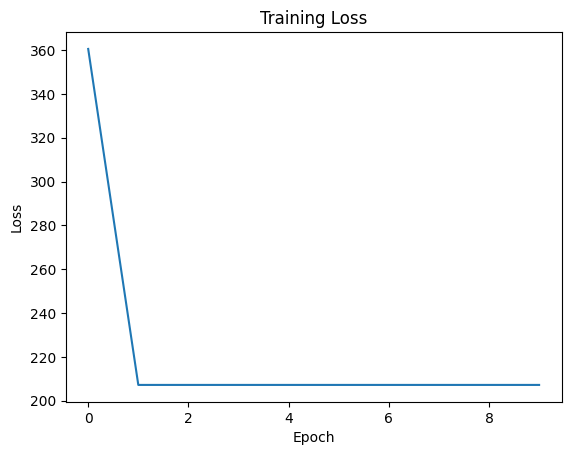

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

In [ ]:
exit()

## Node and Edge Prediction

In [8]:
def node_edge_loss_func(node_pred, node_label, edge_pred, edge_label):
    loss_func = torch.nn.L1Loss()
    node_loss = loss_func(node_pred, node_label)
    edge_loss = loss_func(edge_pred, edge_label)
    return node_loss + edge_loss

In [9]:
model_params = config['model_parameters']['NodeEdgeGNN']
model = NodeEdgeGNN(**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = node_edge_loss_func

trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 19.8859
Epoch [2/10], Training Loss: 0.5544
Epoch [3/10], Training Loss: 0.5644
Epoch [4/10], Training Loss: 0.5930
Epoch [5/10], Training Loss: 9957.7693
Epoch [6/10], Training Loss: 11.2782
Epoch [7/10], Training Loss: 8.7206
Epoch [8/10], Training Loss: 7.9654
Epoch [9/10], Training Loss: 7.1543
Epoch [10/10], Training Loss: 6.4418


Final training Loss: 6.4418
Average training Loss: 1002.0927
Minimum training Loss: 0.5544
Maximum training Loss: 9957.7693
Total training time: 75.1940 seconds
Validation Loss: 5.5277
Inference time: 0.0074 seconds


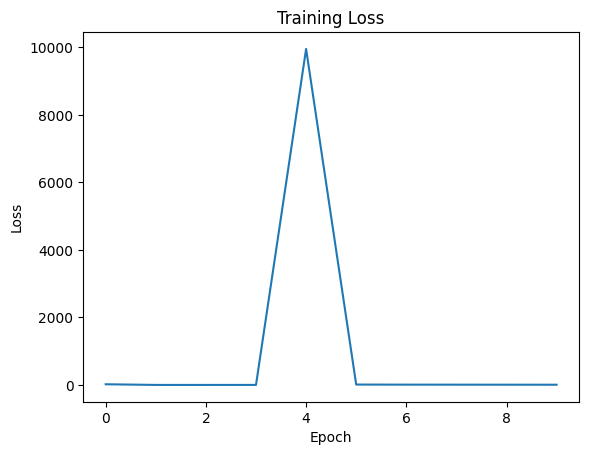

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

In [11]:
# Test with just Node Prediction
model = NodeEdgeGNN(**model_params, **base_model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()
trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device,
                                mode='node')
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 18.1159
Epoch [2/10], Training Loss: 28.9615
Epoch [3/10], Training Loss: 12496.9465
Epoch [4/10], Training Loss: 1.4353
Epoch [5/10], Training Loss: 1.2783
Epoch [6/10], Training Loss: 112.3168
Epoch [7/10], Training Loss: 0.8498
Epoch [8/10], Training Loss: 0.6801
Epoch [9/10], Training Loss: 0.5814
Epoch [10/10], Training Loss: 0.7540


Final training Loss: 0.7540
Average training Loss: 1266.1920
Minimum training Loss: 0.5814
Maximum training Loss: 12496.9465
Total training time: 70.2785 seconds
Validation Loss: 0.0375
Inference time: 0.0054 seconds


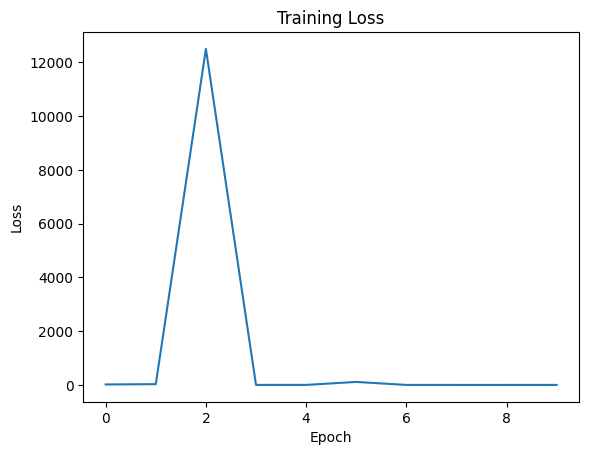

In [12]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Edge Prediction Models

In [ ]:
edge_model_map = {
    'EdgeGNN': EdgeGNN,
}

In [ ]:
model_name = 'EdgeGNN' # Choose from the ff: EdgeGNN
model_params = config['model_parameters'][model_name]
model = edge_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = EdgeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 15.5595
Epoch [2/10], Training Loss: 0.1695
Epoch [3/10], Training Loss: 0.1604
Epoch [4/10], Training Loss: 0.1544
Epoch [5/10], Training Loss: 0.1537
Epoch [6/10], Training Loss: 0.1539
Epoch [7/10], Training Loss: 0.1540
Epoch [8/10], Training Loss: 0.1587
Epoch [9/10], Training Loss: 0.2097
Epoch [10/10], Training Loss: 0.1854


Final training Loss: 0.1854
Average training Loss: 1.7059
Minimum training Loss: 0.1537
Maximum training Loss: 15.5595
Total training time: 9.7774 seconds
Validation Loss: 0.1083
Inference time: 0.0011 seconds


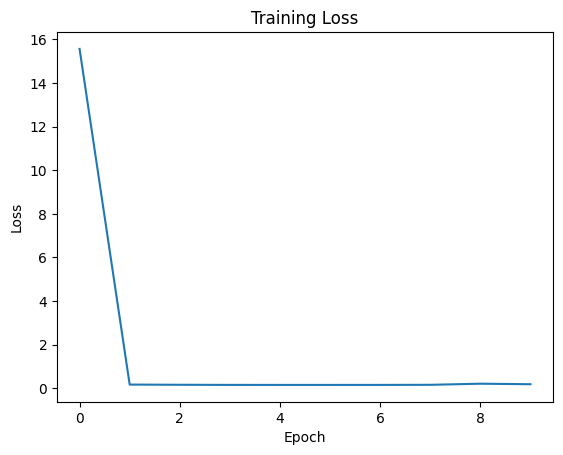

In [ ]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Self-Supervised Learning Methods

In [ ]:
from tqdm import tqdm
from models.graph_mae2 import GraphMAE2
from utils.graph_mae2_utils import LinearRegression

In [ ]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    **config['dataset_parameters']).load()

print(len(dataset))
print(dataset[0])
print(type(dataset[0].x), dataset[0].x.shape)
print(type(dataset[0].edge_index), dataset[0].edge_index.shape)
print(type(dataset[0].edge_attr), dataset[0].edge_attr.shape)
print(type(dataset[0].y), dataset[0].y.shape)
print(info)

336
Data(x=[1268, 6], edge_index=[2, 5224], edge_attr=[5224, 8], y=[1268, 1], pos=[2, 1268])
<class 'torch.Tensor'> torch.Size([1268, 6])
<class 'torch.Tensor'> torch.Size([2, 5224])
<class 'torch.Tensor'> torch.Size([5224, 8])
<class 'torch.Tensor'> torch.Size([1268, 1])
{'num_static_node_features': 3, 'num_dynamic_node_features': 1, 'num_static_edge_features': 5, 'num_dynamic_edge_features': 1, 'previous_timesteps': 2}


In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']
model_info = config['model_parameters']

In [ ]:
def pretrain(model, dataset, optimizer):
    start_time = time.time()

    max_epoch = 20
    epoch_iter = tqdm(range(max_epoch))
    model.to(device)
    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0

        for graph in dataset:
            graph = graph.to(device)
            x = graph.x # Target
            target_nodes = torch.arange(x.shape[0], device=device, dtype=torch.long)

            optimizer.zero_grad()

            loss = model(graph, x, targets=target_nodes)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / num_train
        epoch_iter.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Total pre-training time: {(end_time - start_time):4f} seconds')
    return model

def linear_probing(model, dataset, in_dim, out_dim, lr_f, weight_decay_f):
    start_time = time.time()

    decoder = LinearRegression(in_dim, out_dim).to(device)

    num_finetune_params = [p.numel() for p in decoder.parameters() if  p.requires_grad]
    print(f"num parameters for finetuning: {sum(num_finetune_params)}")

    loss_f = torch.nn.MSELoss()
    optimizer_f = torch.optim.Adam(decoder.parameters(), lr=lr_f, weight_decay=weight_decay_f)

    best_model = None
    max_epoch_f = 50
    epoch_iter_f = tqdm(range(max_epoch_f))
    model.eval()
    decoder.train()
    for epoch in epoch_iter_f:
        running_loss = 0.0

        for graph in dataset:
            optimizer_f.zero_grad()

            graph = graph.to(device)
            with torch.no_grad():
                x = model.embed(graph)
                x = x.to(device)
            label = graph.y

            out = decoder(x)
            loss = loss_f(out, label)

            loss.backward()
            optimizer_f.step()
            running_loss += loss.item()

        epoch_loss = running_loss / num_train
        epoch_iter_f.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Final loss: {epoch_loss:4f}')
    print(f'Total fine-tuning time: {(end_time - start_time):4f} seconds')

    return decoder

def test_ssl(model, ft_model, dataset, loss_func):
    start_time = time.time()
    model.eval()
    ft_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for graph in dataset:
            graph = graph.to(device)
            x = model.embed(graph)
            labels = graph.y

            outputs = ft_model(x)

            loss = loss_func(outputs, labels)
            running_loss += loss.item()
    end_time = time.time()

    # Print validation statistics
    print(f'Validation Loss: {running_loss:.4f}')
    print(f'Inference time: {end_time - start_time} seconds')

In [ ]:
graphmae2_params = model_info['GRAPHMAE2']
in_dim = dataset[0].x.shape[1]
model = GraphMAE2(in_dim=in_dim, **graphmae2_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])

trained_model = pretrain(model, train_dataset, optimizer)

=== Use sce_loss and alpha_l=3 ===


# Epoch 19: train_loss: 0.0224: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Total pre-training time: 95.315137 seconds


In [ ]:
out_dim = dataset[0].y.shape[1]
hidden_dim = graphmae2_params['num_hidden'] // graphmae2_params['nhead']
ft_model = linear_probing(trained_model, train_dataset, hidden_dim, out_dim, 0.0008, lr_info['weight_decay'])

num parameters for finetuning: 2177


# Epoch 49: train_loss: 620.0525: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it] 

Final loss: 620.052530
Total fine-tuning time: 56.627321 seconds


In [ ]:
loss_func = torch.nn.L1Loss()
test_ssl(trained_model, ft_model, test_dataset, loss_func)

Validation Loss: 32728.5642
Inference time: 0.2315971851348877 seconds


In [ ]:
from models.gine.pretrain_contextpred import main

model_file = 'models/gine/trained_model/gine_pretrain'
main(model_file)


cbow
num layer: 5 l1: 4 l2: 7
6
6
6
6
6
====epoch 1


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([12894, 6])
torch.Size([12894, 1])


Iteration:   0%|          | 0/2 [00:20<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 6